In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


# 1. Setup

In [2]:
## Transformer
!pip install transformers --quiet
!pip install datasets transformers[sentencepiece] --quiet
!pip install "transformers[sentencepiece]" --quiet

In [3]:
# import library
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns 
import time
import datetime

In [4]:
df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test_csv = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
test_csv_labels = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
print(df.columns)
print(df.shape)
target_col= df.columns[2:]
feature_col= df.columns[1:2]
df.head()

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
df = df.rename(columns={"id": "idx"})

In [6]:
categories = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [7]:
df[(df["toxic"]==1) | (df["severe_toxic"]==1)| (df["obscene"]==1) | (df["threat"]==1 )| (df["insult"]==1)| (df["identity_hate"]==1)].head()

,idx,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [8]:
df.iloc[5:13,]

,idx,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0
10,0005300084f90edc,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,0,0,0,0,0
11,00054a5e18b50dd4,bbq \n\nbe a man and lets discuss it-maybe ove...,0,0,0,0,0,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0


# 1. Pre-processing & Modelling

In [9]:
# import pyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
# import other parts of transformers as well as tqdm
from transformers import (AutoTokenizer, AutoModel, 
                          AutoModelForSequenceClassification, 
                          DataCollatorWithPadding, AdamW, get_scheduler,
                          get_linear_schedule_with_warmup,
                          )
# import pyarrow (can only import this with GPU on kaggle notebook)
import pyarrow as pa
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import datasets
import random
from sklearn.metrics import classification_report, hamming_loss, accuracy_score

In [10]:
# Setting up seed value
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

## Train, Validation and Test Split

In [11]:
# train & validation, test split
train_val_df, test_df = train_test_split(df[["idx", "comment_text"] + categories], test_size=0.2, random_state=seed_value)

In [12]:
# train, validation split
train_df, val_df, = train_test_split(train_val_df[["idx", "comment_text"] + categories], test_size=0.25, random_state=seed_value)

In [13]:
print(f"Size of train, validation and test are {len(train_df)}, {len(val_df)}, {len(test_df)} respectively.")
print(f"Proportion of train, validation and test are {round(len(train_df)/len(df),2)}, {round(len(val_df)/len(df),2)}, {round(len(test_df)/len(df),2)} respectively.")

Size of train, validation and test are 95742, 31914, 31915 respectively.
Proportion of train, validation and test are 0.6, 0.2, 0.2 respectively.


In [14]:
train_df.reset_index(inplace=True)
train_df.drop("index", axis=1, inplace=True)

val_df.reset_index(inplace=True)
val_df.drop("index", axis=1, inplace=True)

test_df.reset_index(inplace=True)
test_df.drop("index", axis=1, inplace=True)

In [15]:
train_df.head()

,idx,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,f8514b48bbea9f52,"So when the polls close in Ontario at 9:30 pm,...",0,0,0,0,0,0
1,4c5e853732b4aa2d,from blowing up the Earth,0,0,0,0,0,0
2,097dc7f0c8a482a8,=fRENCH lANGUAGE\nThis is the National Library...,0,0,0,0,0,0
3,644c631403602fb9,Wiley Protocol \n\nKnow anything about bioiden...,0,0,0,0,0,0
4,ca98b70deab8bcfc,"""\n.\nNo, the facts are pretty clear. You chan...",0,0,0,0,0,0


## Tokenizing Text in Batches

In [16]:
# instantiate tokenizer, model using "TinyBert"
checkpoint = "huawei-noah/TinyBERT_General_4L_312D"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Downloading:   0%|          | 0.00/409 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [17]:
# tokenize and encode sequences in the training set
train_tokens = tokenizer.batch_encode_plus(train_df["comment_text"].tolist(),
                                           max_length = 200,
                                           pad_to_max_length=True,
                                           truncation=True,
                                           return_token_type_ids=False
                                           )

# tokenize and encode sequences in the validation set
val_tokens = tokenizer.batch_encode_plus(val_df["comment_text"].tolist(),
                                         max_length = 200,
                                         pad_to_max_length=True,
                                         truncation=True,
                                         return_token_type_ids=False
                                         )

# tokenize and encode sequences in the test set
test_tokens = tokenizer.batch_encode_plus(test_df["comment_text"].tolist(),
                                          max_length = 200,
                                          pad_to_max_length=True,
                                          truncation=True,
                                          return_token_type_ids=False
                                          )

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [18]:
## convert lists to tensors
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
# change from a list of 1 & 0 to array then to tensor
train_y = torch.tensor(np.array(train_df[categories]))  

val_seq = torch.tensor(val_tokens['input_ids'])
val_mask = torch.tensor(val_tokens['attention_mask'])
# change from a list of 1 & 0 to array then to tensor
val_y = torch.tensor(np.array(val_df[categories]))

test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
# change from a list of 1 & 0 to array then to tensor
test_y = torch.tensor(np.array(test_df[categories]))

In [19]:
train_y

tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]])

In [20]:
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)

In [21]:
# define a batch size
batch_size = 32

# dataLoader for train set
train_dataloader = DataLoader(train_data, 
                              sampler=train_sampler, 
                              batch_size=batch_size,
                              # collate_fn=data_collator
                              )

# dataLoader for validation set
val_dataloader = DataLoader(val_data, 
                            sampler = val_sampler, 
                            batch_size=batch_size,
                            # collate_fn=data_collator
                            )

No dynamic padding. Above accomodate for fix padding size of 200

In [22]:
for step,batch in enumerate(train_dataloader):
    break
print(batch[0])
print(batch[1])
print(batch[2])

tensor([[  101, 19169, 16407,  ...,     0,     0,     0],
        [  101, 27105, 15693,  ...,     0,     0,     0],
        [  101,  2023,  2003,  ...,     0,     0,     0],
        ...,
        [  101,  3398,  2092,  ...,     0,     0,     0],
        [  101,  2025,  2043,  ...,     0,     0,     0],
        [  101,  2021,  1045,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],


## Setting up Huawei's TinyBert Model (Even lighter version of DistilBert)

In [23]:
# instantiate model using TinyBert"
# Will be training for the whole network instead of just finetuning the weight of the head layer
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 6)

# In the event that we only need to finetune the head layer and not the whole network,
# just need to uncomment the below code

# for param in model.bert.parameters():
#     param.requires_grad = False

# for name, param in model.named_parameters():                
#     if param.requires_grad:
#         print(name)

Downloading:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertForSequenceClassification: ['fit_denses.2.weight', 'fit_denses.2.bias', 'fit_denses.0.weight', 'fit_denses.3.bias', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.0.bias', 'cls.predictions.decoder.weight', 'fit_denses.4.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'fit_denses.1.weight', 'fit_denses.3.weight', 'cls.predictions.transform.dense.bias', 'fit_denses.4.weight', 'fit_denses.1.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a

In [24]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, element

Also need to set up the following before training:

1. Optimizer
2. Scheduler (if want to go add a little decay in the learning rate)
3. Get the right loss function/criterion
4. Specify the right measurement for accuracy (since this is a multi-label problem)

In [25]:
# Set up optimizer
# Will be training for the whole network instead of just finetuning the weight of the head layer
LEARN_RATE = 3e-5
optimizer = AdamW(model.parameters(),
                  lr = LEARN_RATE, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

# In the event that we only need to finetune the head layer and not the whole network,
# just need to uncomment the below code

# optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
#                   lr = LEARN_RATE, # args.learning_rate - default is 5e-5, our notebook had 2e-5
#                   eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
#                   )

# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 1e-5)

In [26]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 3
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # default value
                                            num_training_steps = total_steps
                                            )
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [27]:
# Specify loss function
criterion = nn.BCEWithLogitsLoss()

# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
# This criterion combines LogSoftmax and NLLLoss in one single class.
# More relevant for multiclass (because of the softmax)

# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
# More relevant for multilabel. For more explanation, can refer to the link below.
# https://discuss.pytorch.org/t/using-bcewithlogisloss-for-multi-label-classification/67011/2

In [28]:
# Specify measurement of accuracy
def accuracy_thresh(y_pred, y_true, thresh:float=0.4, sigmoid:bool=True):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: 
        y_pred = y_pred.sigmoid()
    # return ((y_pred>thresh)==y_true.byte()).float().mean().item()
    return np.mean(((y_pred>thresh).float()==y_true.float()).float().cpu().numpy(), axis=1).sum()

In [29]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [30]:
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss & accuracy for this epoch.
    total_train_loss = 0
    total_train_accuracy = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass. 
        # PyTorch doesn't do this automatically because accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments are given and what flags are set. 
        # For our useage here, it returns the loss (because we provided labels) and the "logits"--the model outputs prior to activation.
        output = model(b_input_ids, 
                       # token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       #labels=b_labels
                       )
        logits = output.logits
        loss = criterion(logits, b_labels.float())

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_train_loss += loss.item()
        
        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches.
        total_train_accuracy += accuracy_thresh(logits,b_labels.float())

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Report the final accuracy for this validation run.
    # avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    # print("  Accuracy: {0:.5f}".format(avg_train_accuracy))
    train_accuracy = total_train_accuracy / len(train_df)
    print("  Accuracy: {0:.5f}".format(train_accuracy))
    
    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        # Unpack this training batch from our dataloader. 
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output values prior to applying an activation function like the softmax.
            output = model(b_input_ids, 
                           # token_type_ids=None, 
                           attention_mask=b_input_mask, 
                           # labels=b_labels
                           )
            
            logits = output.logits
            loss = criterion(logits, b_labels.float())
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches.
        total_eval_accuracy += accuracy_thresh(logits,b_labels.float())

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy() # maybe irrelevant over here
        label_ids = b_labels.to('cpu').numpy() # maybe irrelevant over here

    # Report the final accuracy for this validation run.
    # avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    # print("  Accuracy: {0:.5f}".format(avg_val_accuracy))
    val_accuracy = total_eval_accuracy / len(val_df)
    print("  Accuracy: {0:.5f}".format(val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            # 'Training Accur': avg_train_accuracy,
            # 'Valid. Accur.': avg_val_accuracy,
            'Training Accur': train_accuracy,
            'Valid. Accur.': val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  2,992.    Elapsed: 0:00:04.
  Batch    80  of  2,992.    Elapsed: 0:00:07.
  Batch   120  of  2,992.    Elapsed: 0:00:10.
  Batch   160  of  2,992.    Elapsed: 0:00:14.
  Batch   200  of  2,992.    Elapsed: 0:00:17.
  Batch   240  of  2,992.    Elapsed: 0:00:20.
  Batch   280  of  2,992.    Elapsed: 0:00:23.
  Batch   320  of  2,992.    Elapsed: 0:00:27.
  Batch   360  of  2,992.    Elapsed: 0:00:30.
  Batch   400  of  2,992.    Elapsed: 0:00:33.
  Batch   440  of  2,992.    Elapsed: 0:00:36.
  Batch   480  of  2,992.    Elapsed: 0:00:39.
  Batch   520  of  2,992.    Elapsed: 0:00:42.
  Batch   560  of  2,992.    Elapsed: 0:00:46.
  Batch   600  of  2,992.    Elapsed: 0:00:49.
  Batch   640  of  2,992.    Elapsed: 0:00:52.
  Batch   680  of  2,992.    Elapsed: 0:00:55.
  Batch   720  of  2,992.    Elapsed: 0:00:59.
  Batch   760  of  2,992.    Elapsed: 0:01:02.
  Batch   800  of  2,992.    Elapsed: 0:01:05.
  Batch   840  of

In [31]:
# Display floats with two decimal places.
pd.set_option('precision', 5)
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)
# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')
# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])
# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Accur,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,0.07856,0.04635,0.96792,0.98217,0:04:01,0:00:23
2,0.04407,0.04692,0.98319,0.98038,0:04:00,0:00:23
3,0.04002,0.04611,0.98447,0.98062,0:04:00,0:00:23


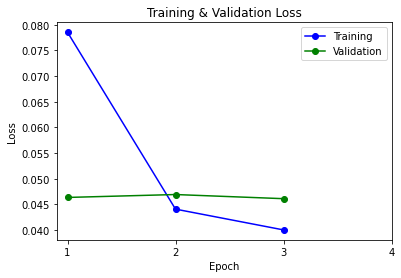

In [32]:
# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

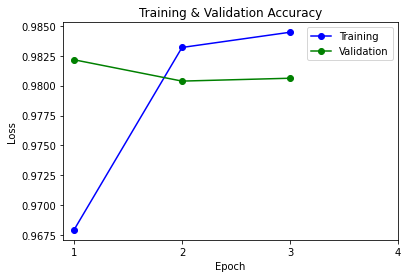

In [33]:
# Plot the accuracy curve.
plt.plot(df_stats['Training Accur'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Accur.'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Get Test Metrics Result

In [34]:
# get predictions for test data
thresh = 0.4
with torch.no_grad():
    outputs = model(test_seq[0:1000].to(device), test_mask[0:1000].to(device))
    pred_probs = torch.sigmoid(outputs.logits)
    pred_probs = pred_probs.cpu().detach().numpy()

In [35]:
pred_probs

array([[1.7445280e-01, 9.5911213e-04, 1.2171942e-02, 1.6018235e-03,
        1.8413594e-02, 3.5295463e-03],
       [1.7660442e-03, 1.8787247e-04, 3.1217057e-04, 6.2279415e-04,
        6.4046832e-04, 7.3499896e-04],
       [1.8303354e-03, 1.8237444e-04, 3.1498194e-04, 5.9733534e-04,
        6.4260495e-04, 7.1443670e-04],
       ...,
       [1.9867870e-03, 1.7777954e-04, 3.2622361e-04, 5.7310786e-04,
        6.6101929e-04, 6.9951877e-04],
       [9.9254084e-01, 4.2102879e-01, 9.6726090e-01, 1.0547969e-01,
        9.2289996e-01, 2.7859619e-01],
       [7.2562742e-01, 5.2786334e-03, 1.3950260e-01, 4.4011138e-03,
        1.4176208e-01, 1.2213573e-02]], dtype=float32)

In [36]:
y_pred = (pred_probs > thresh).astype(int)

In [37]:
y_pred

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0]])

In [38]:
y_true = np.array(test_df[categories])[0:1000]

In [39]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    
    Take in np.array for y_true and y_pred. E.g.
    y_true = np.array([[0,1,0],
                       [0,1,1],
                       [1,0,1],
                       [0,0,1]])

    y_pred = np.array([[0,1,1],
                       [0,1,1],
                       [0,1,0],
                       [0,0,0]])
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [40]:
print("accuracy_score:", accuracy_score(y_true, y_pred))
print("Hamming_score:", hamming_score(y_true, y_pred))
print("Hamming_loss:", hamming_loss(y_true, y_pred))

accuracy_score: 0.925
Hamming_score: 0.9483333333333333
Hamming_loss: 0.016166666666666666


# 2. Saving the Model

In [41]:
PATH = "./toxic_tinyBERT_multilabel"
torch.save(model.state_dict(), PATH)

# 3. Submission

In [42]:
len(test_csv)

153164

In [43]:
test_csv.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [44]:
# tokenize and encode sequences in the actual test set
sub_tokens = tokenizer.batch_encode_plus(test_csv["comment_text"].tolist(),
                                         max_length = 200,
                                         pad_to_max_length=True,
                                         truncation=True,
                                         return_token_type_ids=False
                                         )

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [45]:
sub_seq = torch.tensor(sub_tokens['input_ids'])
sub_mask = torch.tensor(sub_tokens['attention_mask'])

In [46]:
sub_data = TensorDataset(sub_seq, sub_mask)

In [47]:
# dataLoader for validation set
sub_dataloader = DataLoader(sub_data, 
                            batch_size=batch_size)

In [48]:
# Measure how long the evaluation going to takes.
t0 = time.time()

for step, batch in enumerate(sub_dataloader):
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(sub_dataloader), elapsed))
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    with torch.no_grad():
        outputs = model(b_input_ids, b_input_mask)
        pred_probs = torch.sigmoid(outputs.logits)
        if step == 0:
            predictions = pred_probs.cpu().detach().numpy()
        else:
            predictions = np.append(predictions, pred_probs.cpu().detach().numpy(), axis=0)

  Batch    40  of  4,787.    Elapsed: 0:00:01.
  Batch    80  of  4,787.    Elapsed: 0:00:02.
  Batch   120  of  4,787.    Elapsed: 0:00:03.
  Batch   160  of  4,787.    Elapsed: 0:00:04.
  Batch   200  of  4,787.    Elapsed: 0:00:05.
  Batch   240  of  4,787.    Elapsed: 0:00:06.
  Batch   280  of  4,787.    Elapsed: 0:00:07.
  Batch   320  of  4,787.    Elapsed: 0:00:07.
  Batch   360  of  4,787.    Elapsed: 0:00:08.
  Batch   400  of  4,787.    Elapsed: 0:00:09.
  Batch   440  of  4,787.    Elapsed: 0:00:10.
  Batch   480  of  4,787.    Elapsed: 0:00:11.
  Batch   520  of  4,787.    Elapsed: 0:00:12.
  Batch   560  of  4,787.    Elapsed: 0:00:13.
  Batch   600  of  4,787.    Elapsed: 0:00:14.
  Batch   640  of  4,787.    Elapsed: 0:00:15.
  Batch   680  of  4,787.    Elapsed: 0:00:16.
  Batch   720  of  4,787.    Elapsed: 0:00:17.
  Batch   760  of  4,787.    Elapsed: 0:00:18.
  Batch   800  of  4,787.    Elapsed: 0:00:19.
  Batch   840  of  4,787.    Elapsed: 0:00:19.
  Batch   880

In [49]:
predictions_df = pd.DataFrame(predictions, columns = categories)

In [50]:
len(predictions_df)

153164

In [51]:
submission = pd.concat([test_csv["id"], predictions_df], axis=1)

In [52]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.99470,0.61833,0.98231,0.18233,0.95349,0.41148
1,0000247867823ef7,0.00183,0.00018,0.00032,0.00060,0.00064,0.00072
2,00013b17ad220c46,0.00226,0.00018,0.00035,0.00056,0.00071,0.00070
3,00017563c3f7919a,0.00167,0.00020,0.00031,0.00068,0.00065,0.00079
4,00017695ad8997eb,0.00183,0.00018,0.00032,0.00060,0.00064,0.00072


In [53]:
submission.to_csv('submission.csv', index=False, header=True)

# 4. Test for runtime for CPU

In [54]:
# instantiate model using "google/mobilebert-uncased"
checkpoint = "huawei-noah/TinyBERT_General_4L_312D"
PATH = "./toxic_tinyBERT_multilabel"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 6)
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertForSequenceClassification: ['fit_denses.2.weight', 'fit_denses.2.bias', 'fit_denses.0.weight', 'fit_denses.3.bias', 'cls.predictions.transform.LayerNorm.bias', 'fit_denses.0.bias', 'cls.predictions.decoder.weight', 'fit_denses.4.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'fit_denses.1.weight', 'fit_denses.3.weight', 'cls.predictions.transform.dense.bias', 'fit_denses.4.weight', 'fit_denses.1.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a

<All keys matched successfully>

In [55]:
device = torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, element

In [56]:
# Measure how long the evaluation going to takes.
t0 = time.time()

for step, batch in enumerate(sub_dataloader):
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        # Report progress.
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(sub_dataloader), elapsed))
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    with torch.no_grad():
        outputs = model(b_input_ids, b_input_mask)
        pred_probs = torch.sigmoid(outputs.logits)
        if step == 0:
            predictions = pred_probs.cpu().detach().numpy()
        else:
            predictions = np.append(predictions, pred_probs.cpu().detach().numpy(), axis=0)

  Batch    40  of  4,787.    Elapsed: 0:00:58.
  Batch    80  of  4,787.    Elapsed: 0:01:57.
  Batch   120  of  4,787.    Elapsed: 0:02:56.
  Batch   160  of  4,787.    Elapsed: 0:03:54.
  Batch   200  of  4,787.    Elapsed: 0:04:53.
  Batch   240  of  4,787.    Elapsed: 0:05:51.
  Batch   280  of  4,787.    Elapsed: 0:06:50.
  Batch   320  of  4,787.    Elapsed: 0:07:48.
  Batch   360  of  4,787.    Elapsed: 0:08:46.
  Batch   400  of  4,787.    Elapsed: 0:09:44.
  Batch   440  of  4,787.    Elapsed: 0:10:42.
  Batch   480  of  4,787.    Elapsed: 0:11:40.
  Batch   520  of  4,787.    Elapsed: 0:12:38.
  Batch   560  of  4,787.    Elapsed: 0:13:36.
  Batch   600  of  4,787.    Elapsed: 0:14:33.
  Batch   640  of  4,787.    Elapsed: 0:15:32.
  Batch   680  of  4,787.    Elapsed: 0:16:30.
  Batch   720  of  4,787.    Elapsed: 0:17:29.
  Batch   760  of  4,787.    Elapsed: 0:18:27.
  Batch   800  of  4,787.    Elapsed: 0:19:26.
  Batch   840  of  4,787.    Elapsed: 0:20:25.
  Batch   880